In [1]:
import pandas as pd

main = pd.read_csv('../../data/processed_emails.csv',index_col=False)
main.replace(to_replace='NaN', value=None, inplace=True)
main.drop(['message', 'file'], axis = 1, inplace=True)

# Turning date strings int datetime objects
main['date'] = pd.to_datetime(main['date'])

main.head()

/var/folders/xc/qgn4x7m553q861_qsrx3p1gr0000gn/T/ipykernel_4835/3788678487.py:8: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  main['date'] = pd.to_datetime(main['date'])


,text,sender,recipient1,recipient2,recipient3,Subject,folder,date
0,Here is our forecast,phillip.allen@enron.com,tim.belden@enron.com,NaN,NaN,NaN,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",2001-05-14 16:39:00-07:00
1,Traveling to have a business meeting takes the...,phillip.allen@enron.com,john.lavorato@enron.com,NaN,NaN,Re:,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",2001-05-04 13:51:00-07:00
2,test successful. way to go!!!,phillip.allen@enron.com,leah.arsdall@enron.com,NaN,NaN,Re: test,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,2000-10-18 03:00:00-07:00
3,"Randy, Can you send me a schedule of the salar...",phillip.allen@enron.com,randall.gay@enron.com,NaN,NaN,NaN,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,2000-10-23 06:13:00-07:00
4,Let's shoot for Tuesday at 11:45.,phillip.allen@enron.com,greg.piper@enron.com,NaN,NaN,Re: Hello,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,2000-08-31 05:07:00-07:00


In [2]:
def get_quarterly_data(df:pd.DataFrame, year:int) -> list:
    """
    Get quarterly data from the dataframe.
    """

    q1 = df[df['date'] <= pd.to_datetime(f'{year}-03-31 23:59:59-07:00')]
    q2 = df[(df['date'] <= pd.to_datetime(f'{year}-06-30 23:59:59-07:00')) & (df['date'] >= pd.to_datetime(f'{year}-04-01 00:00:00-07:00'))]
    q3 = df[(df['date'] < pd.to_datetime(f'{year}-09-30 23:59:59-07:00')) & (df['date'] >= pd.to_datetime(f'{year}-07-01 00:00:00-07:00'))]
    q4 = df[(df['date'] <= pd.to_datetime(f'{year}-12-31 23:59:59-07:00')) & (df['date'] >= pd.to_datetime(f'{year}-10-01 00:00:00-07:00'))]
    return [q1, q2, q3, q4]

In [3]:
# Making Partitions
data_pre2k = main[main['date'] < pd.to_datetime('2000-01-01 00:00:00-07:00')]
data_2000 = get_quarterly_data(main,2000)
data_2001 = get_quarterly_data(main,2001)
data_2002 = main[(main['date'] < pd.to_datetime('2003-01-01 00:00:00-07:00')) & 
                (main['date'] >= pd.to_datetime('2002-01-01 00:00:00-07:00'))]


Involved Executives
**[Source](https://www.investopedia.com/enron-executives-6831970)**

Known SPEs
**[Source](https://law.bepress.com/cgi/viewcontent.cgi?article=5550&context=expresso)**

In [4]:
executives = ["jeff.skilling@enron.com", "kenneth.lay@enron.com", "andrew.fastow@enron.com","arthur.andersen@enron.com","lou.pai@enron.com"]
SPEs = ["CHEWCO", "LJM1", "LJM2", "LJM", "Raptors", "JEDI"]

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import network_funcs as nf


def net_subgraphs(node_list, title):
  """
  Creates a figure with four subplots, displaying network graphs and subtitles.

  Args:
    node_list: A list containing four NetworkX graphs.
    title: The overall title for the figure.
  """

  # Create a figure with 4 subplots
  fig, axs = plt.subplots(2, 2, figsize=(12, 8))

  # Subplot titles (modify these if needed)
  subtitles = ['Q1', 'Q2', 'Q3', 'Q4']

  colors=['skyblue', 'lightcoral', 'pink', 'lightgreen']
  # Plot each graph and add subtitle
  for i in range(len(node_list)):
      nx.draw_networkx(node_list[i], ax=axs[i // 2, i % 2], with_labels=False, node_size=50, node_color=colors[i], edge_color='gray')
      axs[i // 2, i % 2].set_title(subtitles[i])  # Set subtitle for each subplot

  plt.suptitle(title)
  plt.tight_layout()
  plt.show()


import seaborn as sns  # Import seaborn for bar charts

def visualize_quarterly_centrality(quarterly_networks, year, executives=executives):
  """
  Visualizes degree centrality for each network in a list of quarterly networks.

  Args:
    quarterly_networks: A list of NetworkX graphs representing quarterly networks.
    executives: (Optional) A list of executive node names to exclude.
  """

  # Create a figure with 2x2 subplots
  fig, axs = plt.subplots(2, 2, figsize=(15, 12))
  high_dcs = []
  # Iterate through each quarter's network
  for i, G in enumerate(quarterly_networks):
      # Calculate degree centrality
      degree_cent = nx.degree_centrality(G)


      # Prepare degree centrality data
      name = []
      degree_centrality = []
      for key, value in degree_cent.items():
          name.append(key)
          degree_centrality.append(value)

      cent_df = pd.DataFrame()
      cent_df['name'] = name
      cent_df['degree_centrality'] = degree_centrality
      cent_df = cent_df.sort_values(by='degree_centrality', ascending=False)
      high_dc_item = cent_df['name'].to_list()[:5]
      high_dcs.extend(high_dc_item)
      #cent_df = cent_df[~cent_df['name'].isin(executives)]  # Exclude executives

      # Plot degree centrality for this quarter
      _ = sns.barplot(x='degree_centrality', y='name', data=cent_df[:5], orient='h', ax=axs[i // 2, i % 2])

      # Customize subplot labels and title
      axs[i // 2, i % 2].set_xlabel('Degree Centrality')
      axs[i // 2, i % 2].set_ylabel('Correspondent')
      axs[i // 2, i % 2].set_title(f'Q{i+1}')
  plt.suptitle( f'Top 5 Degree Centrality for Year {year}', fontsize=16)
  plt.tight_layout()
  plt.show()
  return list(set(high_dcs))


def print_emails (df):
    for _, row in df.iterrows():
        print(f"\n{_}: {row['text']}\n")


# Pre Y2k

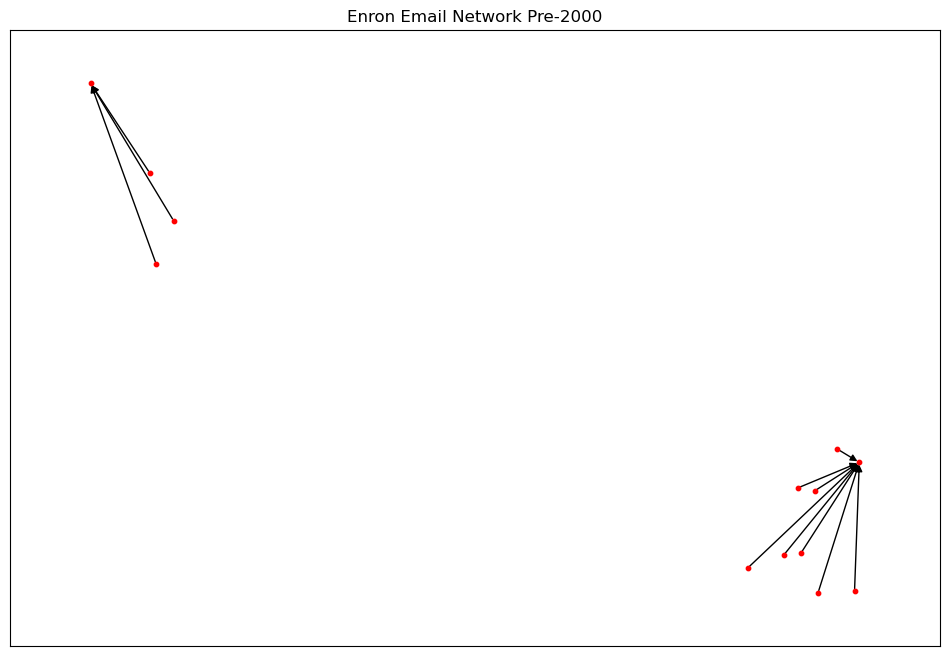

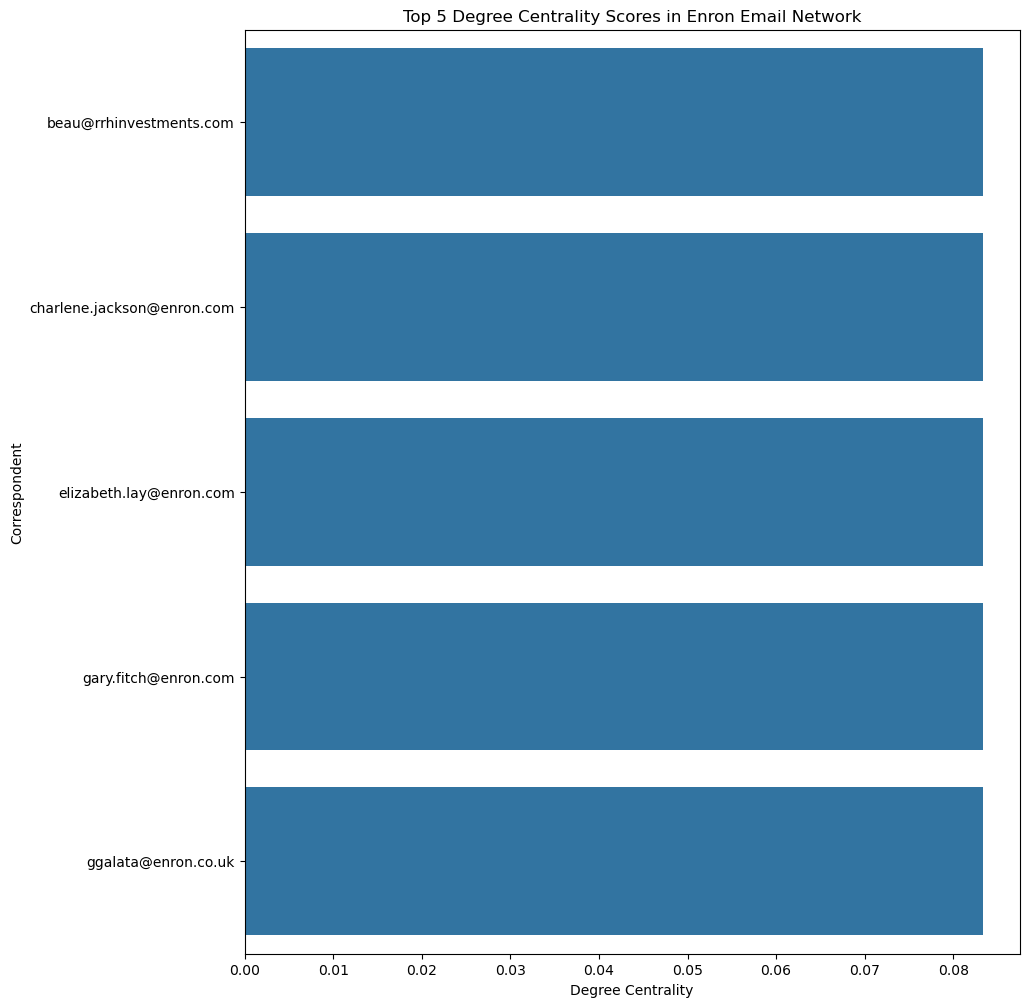

In [6]:
G_pre2k = nf.create_network(data_pre2k, 'Enron Email Network Pre-2000', no_plot=False)
wrongdoers_pre2k = nf.degree_centrality(G_pre2k)['name'].to_list()[:5]

In [7]:
wrongdoing_pre2k = data_pre2k[(data_pre2k['sender'].isin(wrongdoers_pre2k)) | (data_pre2k['recipient1'].isin(wrongdoers_pre2k))]
wrongdoing_pre2k = wrongdoing_pre2k[wrongdoing_pre2k['text'].str.contains('|'.join(SPEs))]

wrongdoing_pre2k

,text,sender,recipient1,recipient2,recipient3,Subject,folder,date


# 2000

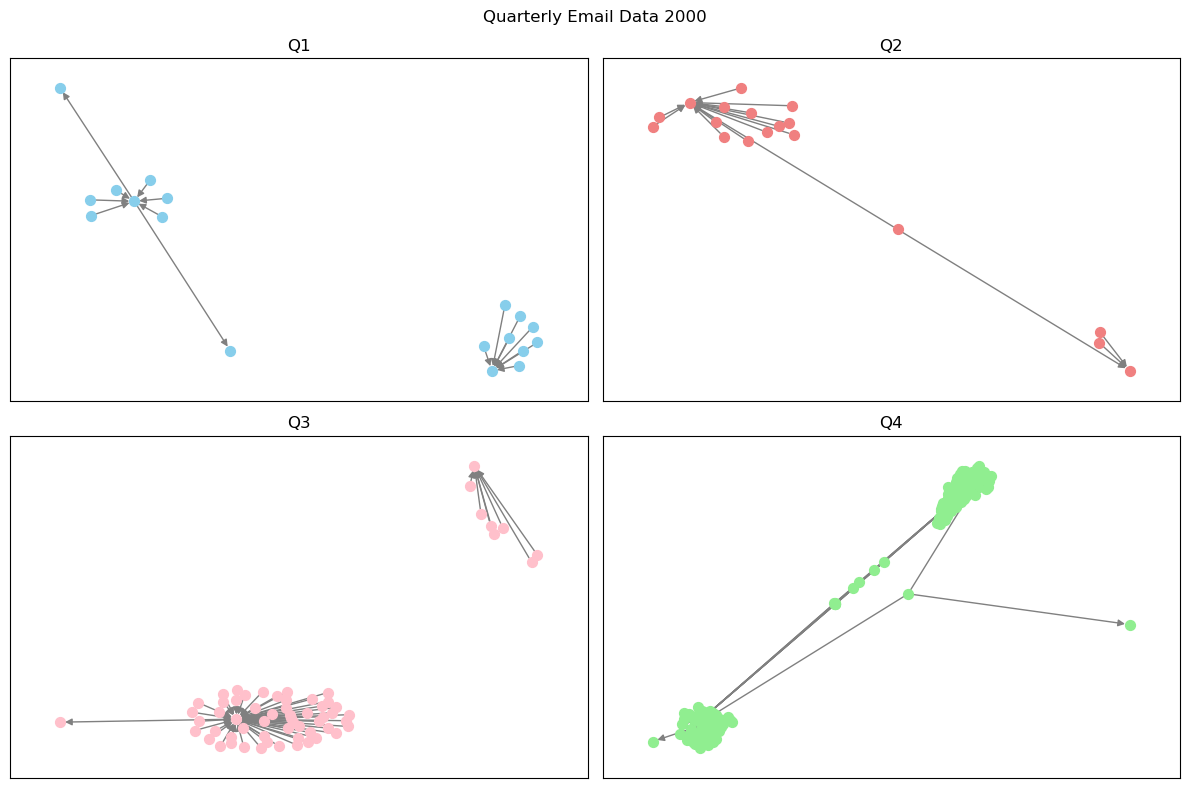

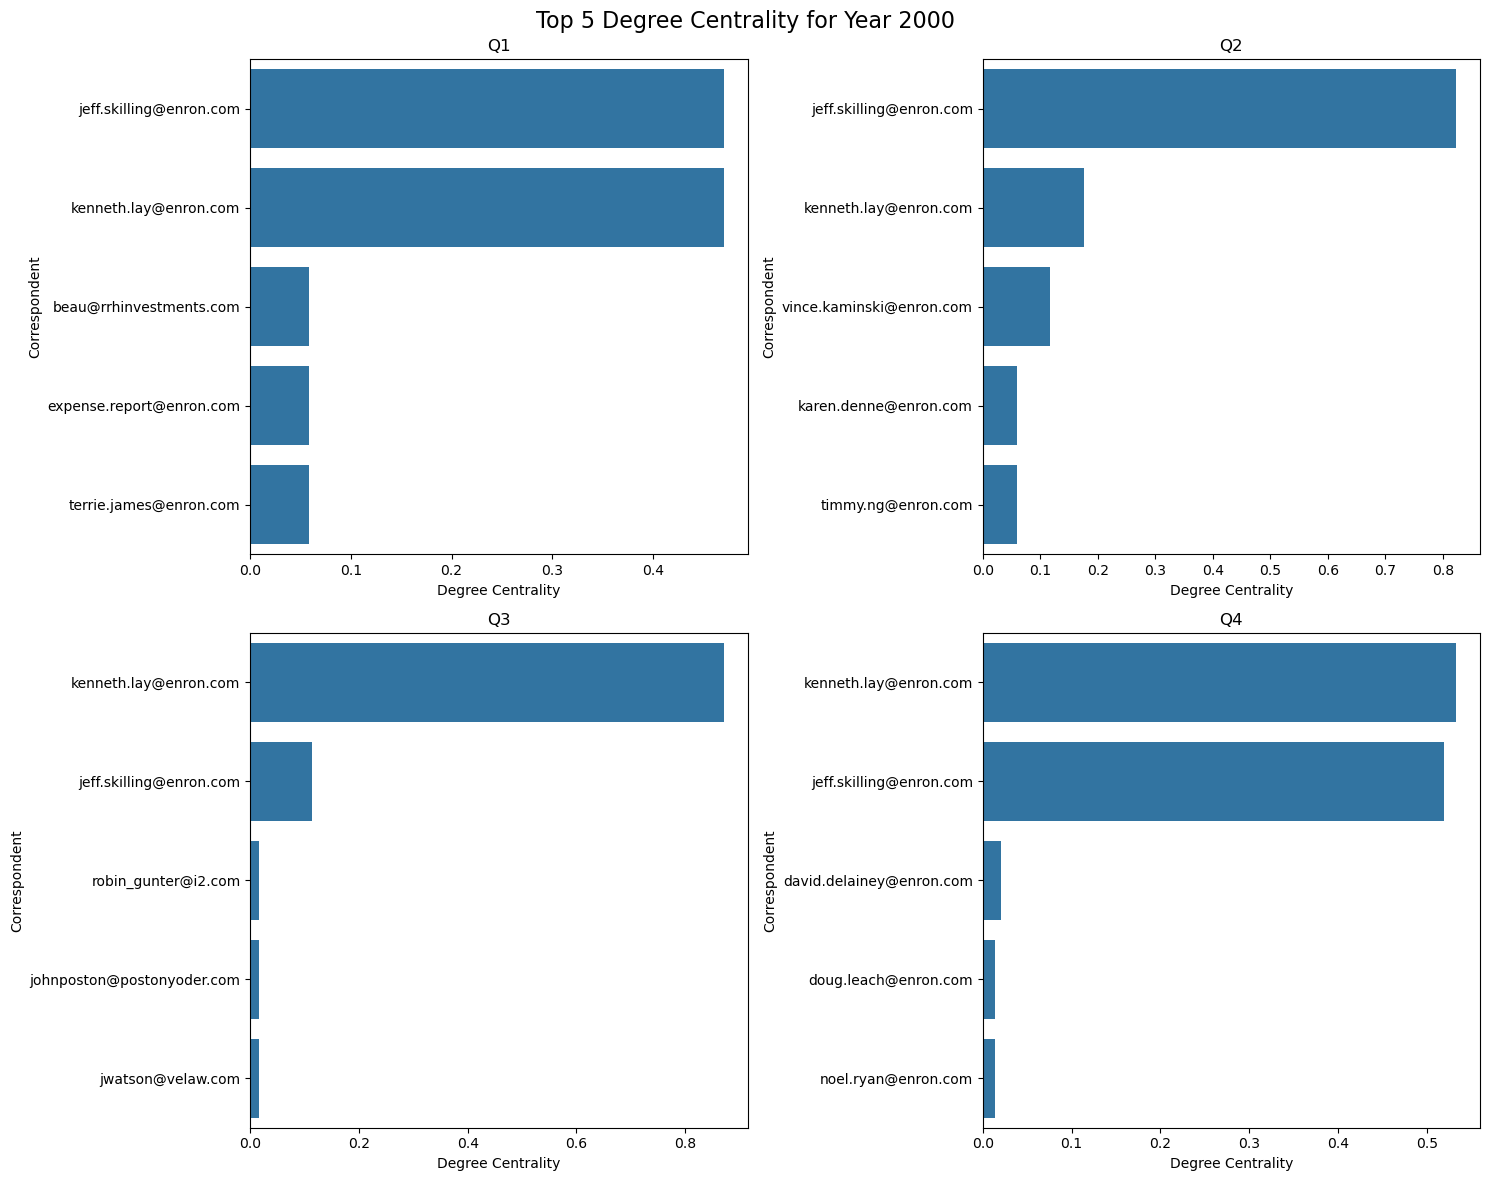

In [8]:
Gs_2000 = [nf.create_network(i) for _, i  in enumerate(data_2000)]
net_subgraphs(Gs_2000, "Quarterly Email Data 2000")
wrongdoers_2000 = visualize_quarterly_centrality(Gs_2000, '2000')

In [9]:
wrongdoing_2000 = pd.concat(data_2000, ignore_index=True)
wrongdoing_2000 = wrongdoing_2000[(wrongdoing_2000['sender'].isin(wrongdoers_2000)) | (wrongdoing_2000['recipient1'].isin(wrongdoers_2000))]

wrongdoing_2000.drop_duplicates(subset=['text'], inplace=True)
wrongdoing_2000 = wrongdoing_2000[wrongdoing_2000['text'].str.contains('|'.join(SPEs))]
print_emails(wrongdoing_2000)


15115: ---------------------- Forwarded by Vince J Kaminski/HOU/ECT on 02/24/2000 04:48 PM ---------------------------Paulo Issler02/24/2000 02:33 PMTo: Vince J Kaminski/HOU/ECT@ECT, Stinson Gibner/HOU/ECT@ECTcc:  Subject: LJMVince/Stinson:The following is an update on LJM deal:1) I participated on a conference call with AA (Jitendra and others) and our Accounting/Credit Group (Wes, Bill Bradford and others) yesturday, in which we discussed the best approach for definining credit reserves at year-end for the puts we own. 2) A big chunck of the meeting was dedicated to explain AA the details of the deal. Little progress was made on achieving the meeting's goal.3) Apparently, Accounting did want to expose the calculation we made for puts value that considers credit risk - the two factor model we developed. That line of action was implied on a pre-meeting we had early that morning. From my understanding, Accounting argues that we should not make any credit reserve because we could not li

# 2001

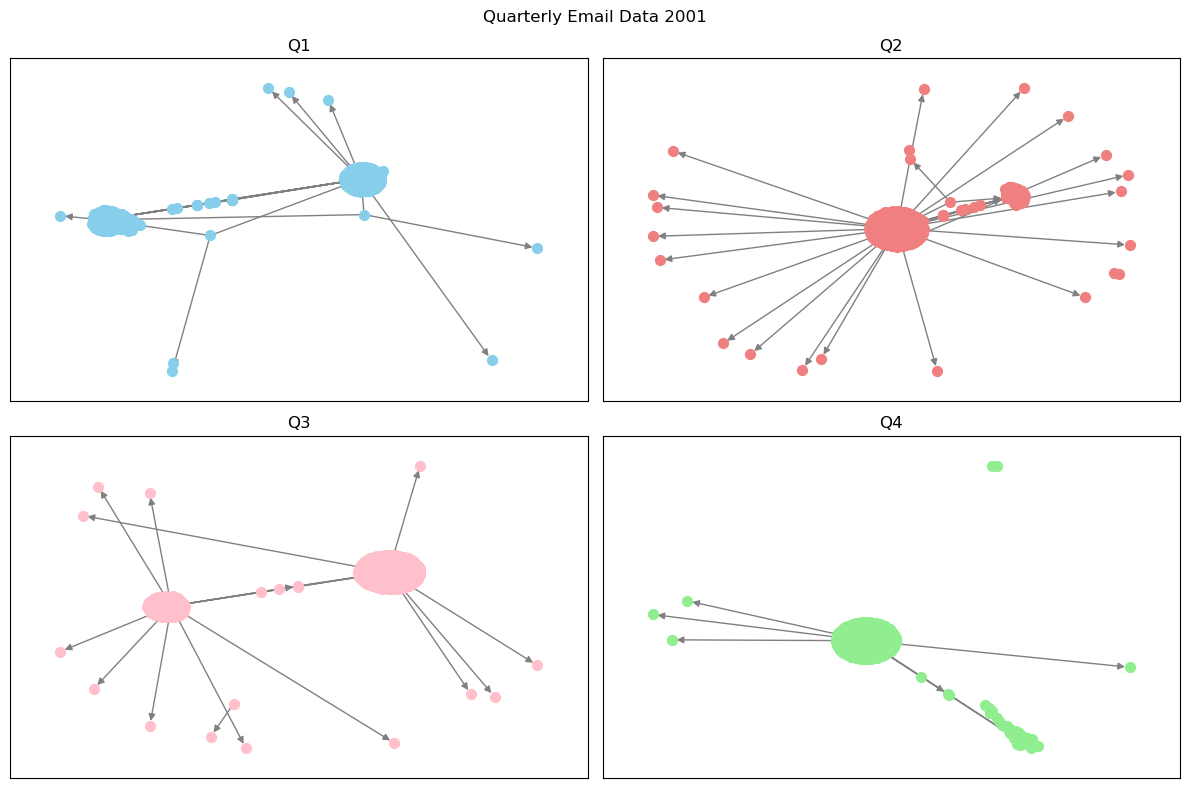

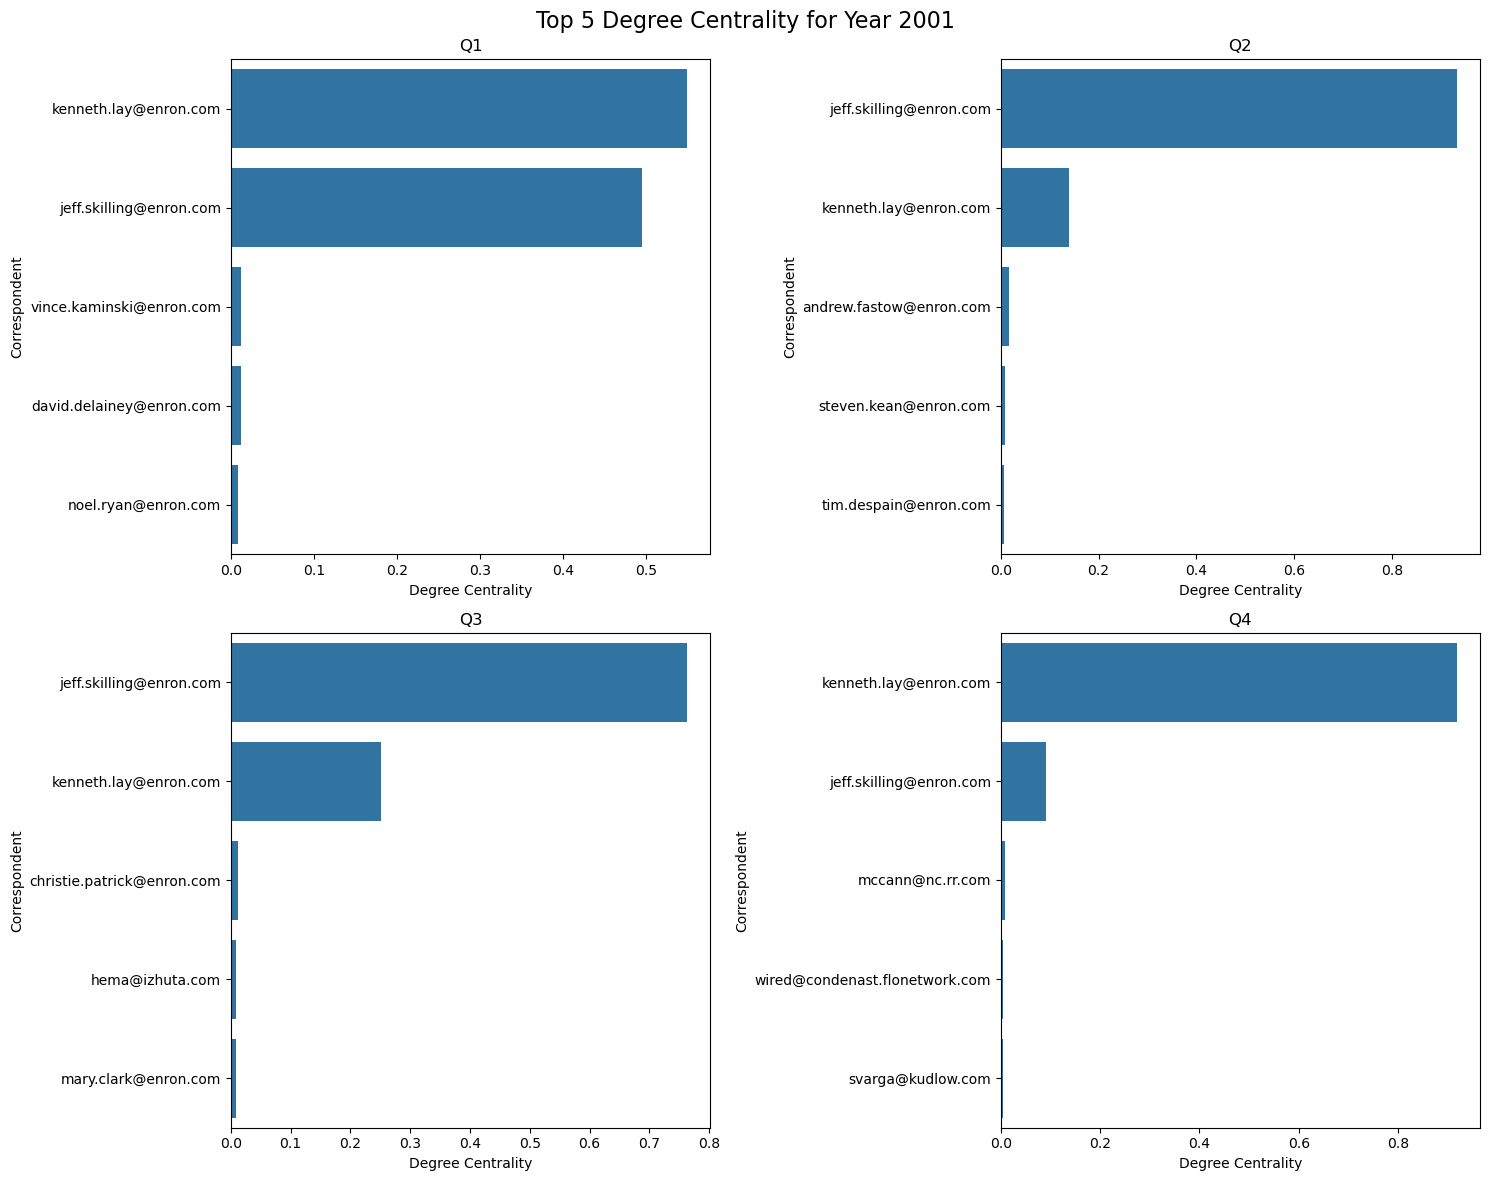

In [10]:
Gs_2001 = [nf.create_network(i) for _, i  in enumerate(data_2001)]
net_subgraphs(Gs_2001, "Quarterly Email Data 2001")
wrongdoers_2001 = visualize_quarterly_centrality(Gs_2001, '2001')

In [11]:
wrongdoing_2001 = pd.concat(data_2001, ignore_index=True)
wrongdoing_2001 = wrongdoing_2001[(wrongdoing_2001['sender'].isin(wrongdoers_2001)) | (wrongdoing_2001['recipient1'].isin(wrongdoers_2001))]

wrongdoing_2001.drop_duplicates(subset=['text'], inplace=True)
wrongdoing_2001 = wrongdoing_2001[wrongdoing_2001['text'].str.contains('|'.join(SPEs))]
print_emails(wrongdoing_2001)


46624: X-Origin: Delainey-DX-FileName: ddelain.nsfGreat job guys  - keep it coming!RegardsDelainey---------------------- Forwarded by David W Delainey/HOU/ECT on 11/02/2000 02:18 PM ---------------------------Richard Lydecker@ENRON11/02/2000 10:07 AMTo: David W Delainey/HOU/ECT@ECT, Brian Redmond/HOU/ECT@ECTcc: Jesse Neyman/HOU/ECT@ECT, Brandi Morris/HOU/ECT@ECT Subject: BrighamWe have completed the sale of our Brigham investment for $20.0 million (JEDI/ENA).  ENA's net share of the proceeds for $12.5 million.   The transaction has been closed and funded and at the book/raptor value.My metaphor for pulling together liquidation transactions of severely distressed assets like Brigham is trying to shield a pencil balanced on its point in the midst of a hurricane.  In the case of the Brigham deal the hurricane was a Force Five.Jempy Neyman, who led the transaction, and Brandi Morris, a senior specialist in Special Assets, did an outstanding job getting this tough deal done.The next "balan

# 2002

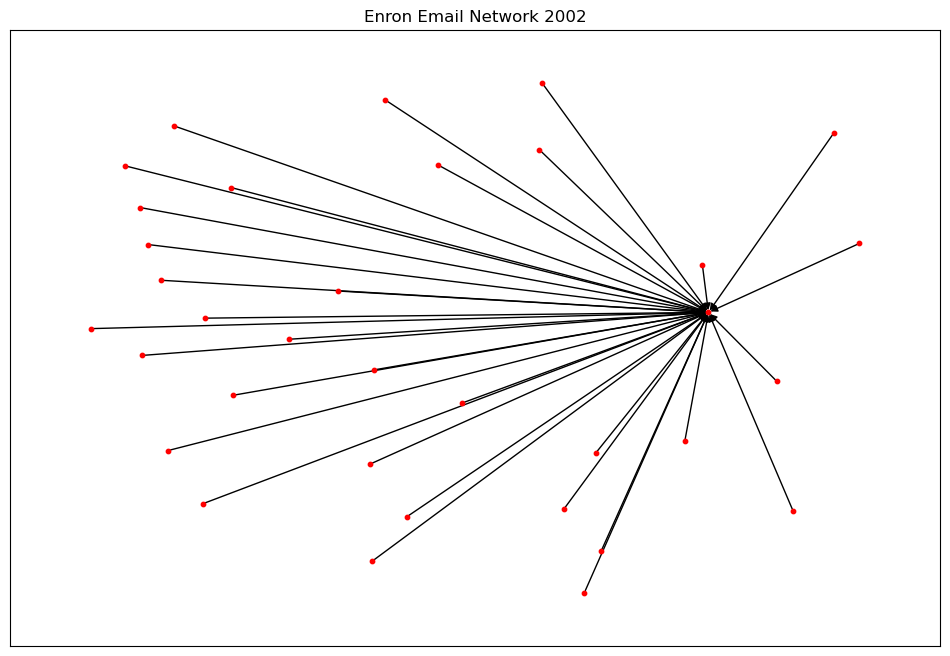

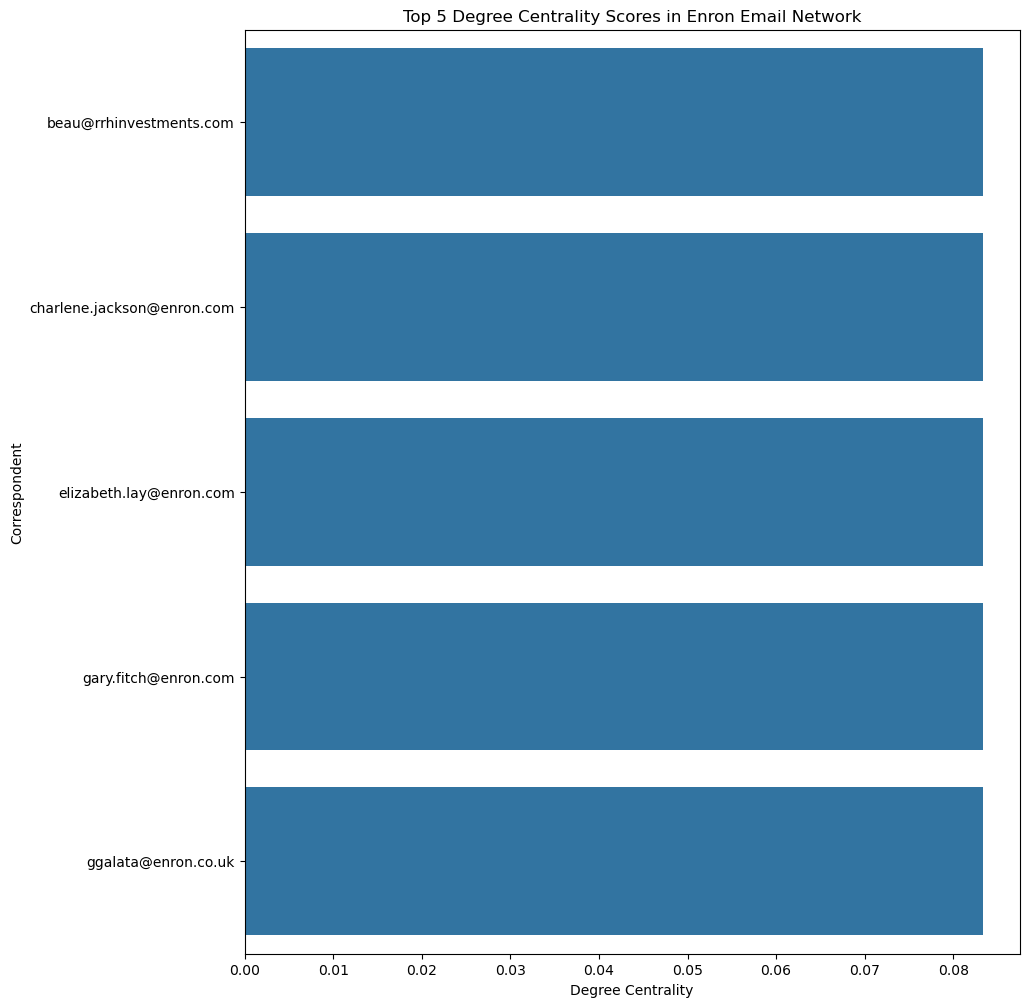

In [12]:
G_2002 = nf.create_network(data_2002, 'Enron Email Network 2002', no_plot=False)
wrongdoers_2002 = nf.degree_centrality(G_pre2k)['name'].to_list()[:5]

In [13]:
wrongdoing_2002 = data_2002[(data_2002['sender'].isin(wrongdoers_2002)) | (data_2002['recipient1'].isin(wrongdoers_2002))]

wrongdoing_2002.drop_duplicates(subset=['text'], inplace=True)
wrongdoing_2002 = wrongdoing_2002[wrongdoing_2002['text'].str.contains('|'.join(SPEs))]
print_emails(wrongdoing_2002)

In [14]:
analysis_results = pd.concat([wrongdoing_pre2k,wrongdoing_2000,wrongdoing_2001,wrongdoing_2002],ignore_index=True)

analysis_results

,text,sender,recipient1,recipient2,recipient3,Subject,folder,date
0,---------------------- Forwarded by Vince J Ka...,vince.kaminski@enron.com,vkaminski@aol.com,NaN,NaN,LJM,\Vincent_Kaminski_Jun2001_8\Notes Folders\'sen...,2000-02-24 08:49:00-08:00
1,---------------------- Forwarded by Vince J Ka...,vince.kaminski@enron.com,vkaminski@aol.com,NaN,NaN,LJM Update,\Vincent_Kaminski_Jun2001_8\Notes Folders\'sen...,2000-02-16 23:59:00-08:00
2,---------------------- Forwarded by Vince J Ka...,vince.kaminski@enron.com,vkaminski@aol.com,NaN,NaN,Re: Model Development Review,\Vincent_Kaminski_Jun2001_8\Notes Folders\'sen...,1999-12-30 08:33:00-08:00
3,X-Origin: Delainey-DX-FileName: ddelain.nsfTha...,david.delainey@enron.com,mike.jakubik@enron.com,X-From: David W Delainey,X-To: Mike Jakubik,Re: Raptor,X-cc: Raymond Bowen,2000-05-11 07:32:00-07:00
4,FYI---------------------- Forwarded by David W...,david.delainey@enron.com,steve.pruett@enron.com,NaN,NaN,Re: C-Gas,\David_Delainey_Dec2000\Notes Folders\'sent mail,2000-07-24 09:01:00-07:00
5,"Jeff, my team believes that there should be a ...",david.delainey@enron.com,jeffrey.sherrick@enron.com,NaN,NaN,Re: C-Gas,\David_Delainey_Dec2000\Notes Folders\'sent mail,2000-07-19 14:34:00-07:00
6,X-Origin: Delainey-DX-FileName: ddelain.nsfGre...,david.delainey@enron.com,richard.lydecker@enron.com,X-From: David W Delainey,X-To: Richard Lydecker,Brigham,"X-cc: Jesse Neyman, Brandi Morris",2000-11-02 06:19:00-08:00
7,"Chris, do you have a deal book -explaining the...",david.delainey@enron.com,christopher.calger@enron.com,NaN,NaN,PSCO,\David_Delainey_Dec2000\Notes Folders\'sent mail,2000-10-09 06:38:00-07:00
8,X-Origin: Delainey-DX-FileName: ddelain.nsfChr...,david.delainey@enron.com,christopher.calger@enron.com,X-From: David W Delainey,X-To: Christopher F Calger,Update on Pastoria and Las Vegas Sale,X-cc: Wes Colwell,2000-11-20 03:36:00-08:00
9,---------------------- Forwarded by Vince J Ka...,vince.kaminski@enron.com,vkaminski@aol.com,NaN,NaN,Off-balance sheet Deal JEDI II,\Vincent_Kaminski_Jun2001_4\Notes Folders\'sen...,2000-12-22 09:54:00-08:00


In [15]:
analysis_results.to_csv('./results/network_results.csv', index=False)